In [41]:
from qualibrate import QualibrationNode
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.polynomial import Polynomial

In [2]:
node  = QualibrationNode(name="quantum_memory_gate_error")

2026-02-18 11:46:00,281 - qualibrate - INFO - Creating node quantum_memory_gate_error


In [3]:
from pathlib import Path
data_path = Path('/Users/jackchao/Desktop/Project/publication/quantum_memory/data_availability/quantum_memory_data/data/QPT_gate_error_vs_fidelity')

In [33]:
gate_error_idx = np.arange(753,953,1)
gate_error = []
fidelity = []
robustness = []
for idx in gate_error_idx:
    res = node.load_from_id(idx,base_path = data_path).results
    gate_error.append(res['initial_parameters']['alpha']-1)
    fidelity.append(res['results']['q0']['quantum information']['mitigated']['fidelity']) 
    robustness.append(res['results']['q0']['quantum information']['mitigated']['Quantum Memory Robustness'])


In [36]:
def ideal_fidelity(alpha):
    return np.cos(alpha*np.pi/2) * (1 + np.cos(alpha*np.pi/2)) / 2
def ideal_robustness(alpha):
    return np.cos(alpha*np.pi/2)**2+ np.cos(alpha*np.pi/2) - 1

Text(0.5, 1.0, 'Robustness vs Fidelity')

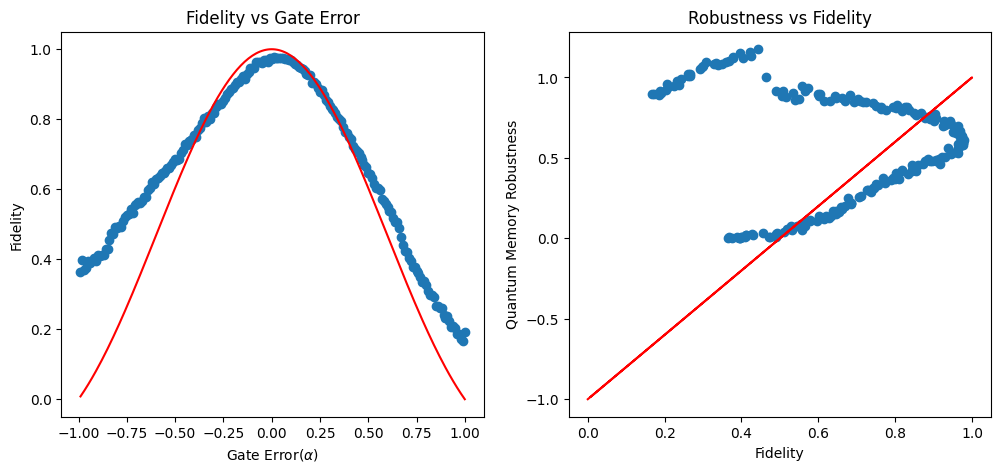

In [39]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(gate_error, fidelity, 'o')
ax[0].plot(gate_error, ideal_fidelity(np.array(gate_error)), 'r-', label='Ideal Fidelity')
ax[0].set_xlabel('Gate Error($\\alpha$)')
ax[0].set_ylabel('Fidelity')
ax[0].set_title('Fidelity vs Gate Error')

ax[1].plot(fidelity, robustness, 'o')
ax[1].plot(ideal_fidelity(np.array(gate_error)), ideal_robustness(np.array(gate_error)), 'r-', label='Ideal Robustness')
ax[1].set_xlabel('Fidelity')
ax[1].set_ylabel('Quantum Memory Robustness')
ax[1].set_title('Robustness vs Fidelity')

# Load QPT ellipsoid gate error data

In [42]:
# Read the CSV file
csv_path = "/Users/jackchao/Desktop/Project/Phd_thesis/CH5_5GZdemonstration/data/Quantum_memory_referee/QPT10000_ellipsoid180_robustness_data.csv"
df = pd.read_csv(csv_path)


In [44]:
filter_std_parameter = 0.3
# Extract columns from dataframe
x_data_all = df['gate_fidelity'].values
ellipsoid_y_all = df['ellipsoid_robustness'].values
ellipsoid_err_all = df['ellipsoid_robustness_std'].values
QPT_y_all = df['QPT_robustness'].values
QPT_err_all = df['QPT_robustness_std'].values

# Filter by ellipsoid std: keep points with std below median + filter_std_parameter*std
# AND filter by gate fidelity: keep points with gate fidelity >= 0.84
# AND filter by robustness: keep points with robustness >= 0.73
err_threshold = np.median(ellipsoid_err_all) + filter_std_parameter*np.std(ellipsoid_err_all)
filter_mask = (ellipsoid_err_all <= err_threshold) & (x_data_all >= 0.7) 
# filter_mask = None
x_data = x_data_all[filter_mask]
ellipsoid_y = ellipsoid_y_all[filter_mask]
ellipsoid_err = ellipsoid_err_all[filter_mask]
QPT_y = QPT_y_all[filter_mask]
QPT_err = QPT_err_all[filter_mask]

In [45]:
# Fit linear regression for both datasets
p_QPT = Polynomial.fit(x_data, QPT_y, 1)
p_ellipsoid = Polynomial.fit(x_data, ellipsoid_y, 1)

# Generate fitting lines
x_fit = np.linspace(x_data.min(), x_data.max()+0.1, 100)
QPT_y_fit = p_QPT(x_fit)
ellipsoid_y_fit = p_ellipsoid(x_fit)

print(f"Fitted Results:")
print(f"\nQPT: y = {p_QPT.coef[1]:.6f} * x + {p_QPT.coef[0]:.6f}")
print(f"Ellipsoid: y = {p_ellipsoid.coef[1]:.6f} * x + {p_ellipsoid.coef[0]:.6f}")

Fitted Results:

QPT: y = 0.209261 * x + 0.742352
Ellipsoid: y = 0.002527 * x + 0.932232


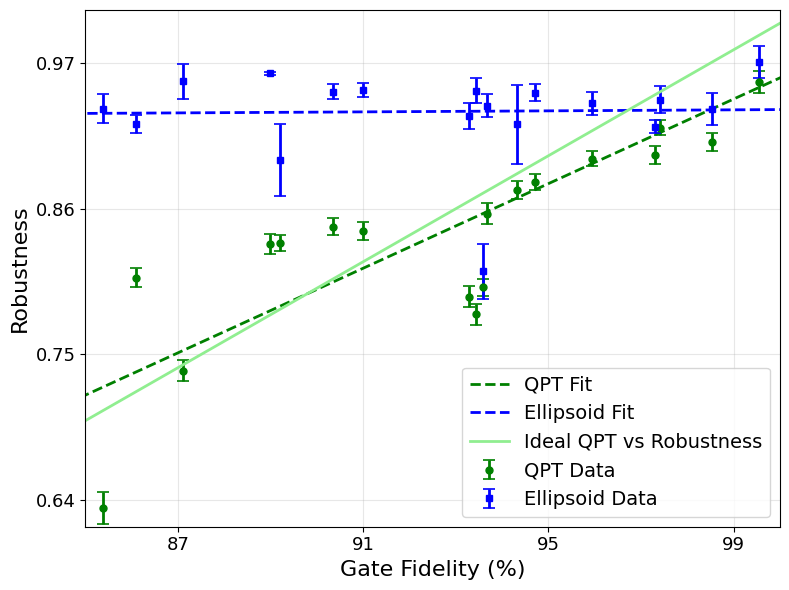


Fitted Results (x in percentage scale [85, 100])

QPT:
  y = 0.002093 * x + 0.742352
  OR: y = 0.209261 * x + 0.742352  (x in [0, 1])

Ellipsoid:
  y = 0.000025 * x + 0.932232
  OR: y = 0.002527 * x + 0.932232  (x in [0, 1])


In [62]:
# Convert to percentage scale for plotting (multiply by 100)
x_plot = x_data * 100
x_fit_plot = x_fit * 100

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Plot QPT data
ax.errorbar(x_plot, QPT_y, yerr=QPT_err,
                    linestyle='none', fmt='o', markersize=5, markerfacecolor='green', 
                    markeredgecolor='green', ecolor='green', elinewidth=2, capsize=4, capthick=1.2,
                    label='QPT Data')
ax.plot(x_fit_plot, QPT_y_fit, 'g--', linewidth=2, label='QPT Fit')

# Plot Ellipsoid data
ax.errorbar(x_plot, ellipsoid_y, yerr=ellipsoid_err,
                    linestyle='none', fmt='s', markersize=5, markerfacecolor='blue', 
                    markeredgecolor='blue', ecolor='blue', elinewidth=2, capsize=4, capthick=1.2,
                    label='Ellipsoid Data')
ax.plot(x_fit_plot, ellipsoid_y_fit, 'b--', linewidth=2, label='Ellipsoid Fit')

#plot theory data
gate_error = np.linspace(0,0.4,100)
ax.plot(ideal_fidelity(gate_error)*100, ideal_robustness(gate_error), color='#90EE90', linewidth=2, label='Ideal QPT vs Robustness')

# Customize plot
ax.set_xlim(85, 100)
ax.set_ylim(0.62, 1.01)
ax.set_xlabel('Gate Fidelity (%)', fontsize=16)
ax.set_ylabel('Robustness', fontsize=16)
ax.tick_params(axis='x', labelsize=13) 
ax.tick_params(axis='y', labelsize=13) 
ax.set_xticks([87, 91 ,95, 99])
ax.set_yticks([0.64, 0.75, 0.86, 0.97])
ax.grid(True, alpha=0.3)
ax.legend(fontsize=14)

plt.tight_layout()
plt.show()

# Print fit results
print(f"\n{'='*60}")
print(f"Fitted Results (x in percentage scale [85, 100])")
print(f"{'='*60}")
a_QPT = p_QPT.coef[1] / 100
b_QPT = p_QPT.coef[0]
print(f"\nQPT:")
print(f"  y = {a_QPT:.6f} * x + {b_QPT:.6f}")
print(f"  OR: y = {p_QPT.coef[1]:.6f} * x + {b_QPT:.6f}  (x in [0, 1])")

a_ellipsoid = p_ellipsoid.coef[1] / 100
b_ellipsoid = p_ellipsoid.coef[0]
print(f"\nEllipsoid:")
print(f"  y = {a_ellipsoid:.6f} * x + {b_ellipsoid:.6f}")
print(f"  OR: y = {p_ellipsoid.coef[1]:.6f} * x + {b_ellipsoid:.6f}  (x in [0, 1])")
print(f"{'='*60}")

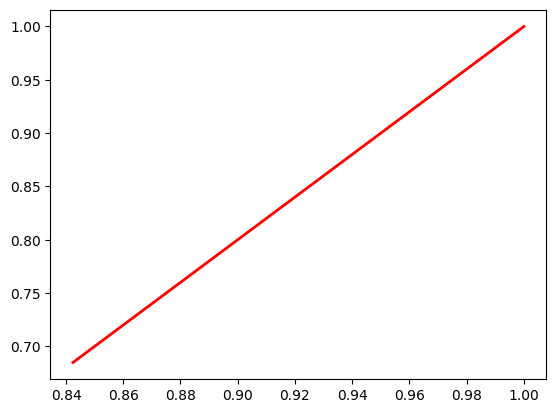

In [50]:
plt.plot(ideal_fidelity(gate_error), ideal_robustness(gate_error), 'r-', linewidth=2, label='Ideal Robustness')
plt.show()